Read-in ReaSCAN and Manipulate

In [121]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))
from ReaSCAN_dataset import *

# Init of the vocab.
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = ReaSCANVocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)

In [2]:
# Read-in info.
path_to_data = "../../../data-files/ReaSCAN-Simple/data-compositional-splits.txt"
ReaSCAN_data_json = json.load(open(path_to_data, "r"))

command: walk,to,the,big,yellow,cylinder,cautiously


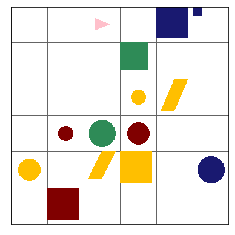

action: ['walk', 'walk', 'turn right', 'walk', 'walk']


In [3]:
example = ReaSCAN_data_json["examples"]["train"][random.randint(0, len(ReaSCAN_data_json["examples"]["train"])-1)]
command = example["command"]
print(f"command: {command}")
situation = example["situation"]
world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world.clear_situation()
for obj_idx, obj in situation["placed_objects"].items():
    world.place_object(
        Object(size=int(obj["object"]["size"]), color=obj["object"]["color"], shape=obj["object"]["shape"]), 
        position=Position(row=int(obj["position"]["row"]), column=int(obj["position"]["column"]))
    )
world.place_agent_at(
    Position(
        row=int(situation["agent_position"]["row"]), 
        column=int(situation["agent_position"]["column"])
))
_ = world.render_simple()

# HERE: you can change to other target object.
target_position = Position(
    row=int(situation['target_object']['position']["row"]), 
    column=int(situation['target_object']['position']["column"])
)
world.go_to_position(position=target_position, manner='', primitive_command="walk")
target_commands, target_demonstration = world.get_current_observations()
print(f"action: {target_commands}")

Prepare for the new length split.

In [25]:
path_to_data = "../../../codes/Reason-SCAN/data-files/ReaSCAN-Causal-new-action-sequence/data-train.txt"
ReaSCAN_data_json = json.load(open(path_to_data, "r"))

In [50]:
all_data = ReaSCAN_data_json["examples"]["train"]
max_target_commands_len = -1
for example in all_data:
    seq_len = len(example['target_commands'].split(","))
    if seq_len > max_target_commands_len:
        max_target_commands_len = seq_len

In [51]:
print(max_target_commands_len)

13


In [52]:
in_dist_data = []
out_dist_data = []
for example in all_data:
    seq_len = len(example['target_commands'].split(","))
    if seq_len >= 12: # 12 or 13
        out_dist_data += [example]
    else:
        in_dist_data += [example]

In [53]:
train_len = 85000 # we want to lower this number a bit from the fullset to make training time reasonable.
eval_len = int(len(in_dist_data)*0.05) # let us take 5% for dev and test.

In [54]:
import random
random.shuffle(in_dist_data)
train_set = in_dist_data[:train_len]
dev_set = in_dist_data[-2*eval_len:-eval_len]
test_set = in_dist_data[-eval_len:]

In [55]:
ReaSCAN_data_json["examples"] = {
    "train":train_set,
    "test":test_set,
    "dev":dev_set,
    "new_action_length":out_dist_data
}

In [56]:
# dump to the disk.
with open("../../../data-files/ReaSCAN-novel-action-length/data-compositional-splits.txt", "w") as fd:
    json.dump(ReaSCAN_data_json, fd, indent=4)

Prepare for the new direction split. 

In [79]:
path_to_data = "../../../codes/Reason-SCAN/data-files/ReaSCAN-Causal-new-action-sequence/data-train.txt"
ReaSCAN_data_json = json.load(open(path_to_data, "r"))

In [83]:
all_data = ReaSCAN_data_json["examples"]["train"]
in_dist_data = []
out_dist_data = []
for example in all_data:
    if "walk" not in example["command"]:
        assert False
    if example["adverb_in_command"] != "":
        assert False
    agent_r = int(example['situation']['agent_position']["row"])
    agent_c = int(example['situation']['agent_position']["column"])
    target_r = int(example['situation']['target_object']['position']["row"])
    target_c = int(example['situation']['target_object']['position']["column"])
    r_diff = target_r-agent_r
    c_diff = target_c-agent_c
    if r_diff > 0 and c_diff < 0:
        out_dist_data += [example]
    else:
        in_dist_data += [example]

In [85]:
train_len = 85000 # we want to lower this number a bit from the fullset to make training time reasonable.
eval_len = int(len(in_dist_data)*0.05) # let us take 5% for dev and test.

In [86]:
import random
random.shuffle(in_dist_data)
train_set = in_dist_data[:train_len]
dev_set = in_dist_data[-2*eval_len:-eval_len]
test_set = in_dist_data[-eval_len:]

In [87]:
random.shuffle(out_dist_data)
ReaSCAN_data_json["examples"] = {
    "train":train_set,
    "test":test_set,
    "dev":dev_set,
    "new_direction":out_dist_data[:8000]
}

In [88]:
# dump to the disk.
with open("../../../data-files/ReaSCAN-novel-direction/data-compositional-splits.txt", "w") as fd:
    json.dump(ReaSCAN_data_json, fd, indent=4)

Prepare for the new attribute split.

In [89]:
path_to_data = "../../../codes/Reason-SCAN/data-files/ReaSCAN-Causal-new-attribute/data-train.txt"
ReaSCAN_data_json = json.load(open(path_to_data, "r"))

In [90]:
all_data = ReaSCAN_data_json["examples"]["train"]

In [92]:
new_color = []
new_size = []
in_dist_data = []
for example in all_data:
    if "yellow,square" in example['command']:
        new_color += [example]
    elif "small,cylinder" in example['command'] or \
        "small,red,cylinder" in example['command'] or \
        "small,blue,cylinder" in example['command'] or \
        "small,yellow,cylinder" in example['command'] or \
        "small,green,cylinder" in example['command']:
        new_size += [example]
    else:
        in_dist_data += [example]

In [96]:
train_len = 85000 # we want to lower this number a bit from the fullset to make training time reasonable.
eval_len = int(len(in_dist_data)*0.05) # let us take 5% for dev and test.

In [97]:
import random
random.shuffle(in_dist_data)
train_set = in_dist_data[:train_len]
dev_set = in_dist_data[-2*eval_len:-eval_len]
test_set = in_dist_data[-eval_len:]

In [98]:
random.shuffle(new_color)
random.shuffle(new_size)
ReaSCAN_data_json["examples"] = {
    "train":train_set,
    "test":test_set,
    "dev":dev_set,
    "new_color":new_color[:8000],
    "new_size":new_size[:8000],
}

In [99]:
# dump to the disk.
with open("../../../data-files/ReaSCAN-novel-attribute/data-compositional-splits.txt", "w") as fd:
    json.dump(ReaSCAN_data_json, fd, indent=4)

In [123]:
# let us filter out very long sequence length
# they are not the focus on this project and
# burden training time a lot : )
path_to_data = "../../../data-files/ReaSCAN-novel-attribute/data-compositional-splits.txt"
ReaSCAN_data_json = json.load(open(path_to_data, "r"))

In [134]:
new_color = []
new_size = []
train_data = []
dev_data = []
test_data = []
for k, v in ReaSCAN_data_json["examples"].items():
    for example in v:
        action_len = len(example["target_commands"].split(","))
        if action_len > 35:
            continue
        if k == "train":
            train_data += [example]
        elif k == "dev":
            dev_data += [example]
        elif k == "test":
            test_data += [example]
        elif k == "new_color":
            new_color += [example]
        elif k == "new_size":
            new_size += [example]
        else:
            assert False

In [138]:
ReaSCAN_data_json["examples"] = {
    "train":train_data,
    "test":test_data,
    "dev":dev_data,
    "new_color":new_color[:8000],
    "new_size":new_size[:8000],
}

In [139]:
# dump to the disk.
with open("../../../data-files/ReaSCAN-novel-attribute/data-compositional-splits.txt", "w") as fd:
    json.dump(ReaSCAN_data_json, fd, indent=4)

Generate vocab files for each split.

In [101]:
dataset_path = "../../../data-files/"
datasets = [
    "ReaSCAN-novel-direction",
    "ReaSCAN-novel-attribute",
    "ReaSCAN-novel-action-length"
]

In [102]:
basic_stats = {}
for ds in datasets:
    path_to_data = os.path.join(dataset_path, ds, "data-compositional-splits.txt")
    ReaSCAN_data_json = json.load(open(path_to_data, "r"))
    print(f"procecssing dataset={ds}")
    train_dataset = ReaSCANDataset(
        data_json=ReaSCAN_data_json, 
        save_directory=os.path.join(dataset_path, ds), 
        k=0, 
        split="train", 
        generate_vocabulary=True
    )
    train_dataset.save_vocabularies(
        input_vocabulary_file="input_vocabulary.txt", 
        target_vocabulary_file="target_vocabulary.txt"
    )

2021-09-10 13:14 Formulating the dataset from the passed in json file...
2021-09-10 13:14 Generating vocabularies...
2021-09-10 13:14 Populating vocabulary...


procecssing dataset=ReaSCAN-novel-direction


2021-09-10 13:17 Done generating vocabularies.
2021-09-10 13:17 Formulating the dataset from the passed in json file...
2021-09-10 13:17 Generating vocabularies...
2021-09-10 13:17 Populating vocabulary...


procecssing dataset=ReaSCAN-novel-attribute


2021-09-10 13:19 Done generating vocabularies.
2021-09-10 13:20 Formulating the dataset from the passed in json file...
2021-09-10 13:20 Generating vocabularies...
2021-09-10 13:20 Populating vocabulary...


procecssing dataset=ReaSCAN-novel-action-length


2021-09-10 13:22 Done generating vocabularies.


Dataset verification

In [103]:
# we will simply verify all testing vocab are seen during training.
# for novel attributes, we want to make sure different composits are
# seen during training.

In [104]:
# verify all examples contain three turn left as it is in SW.
ds = "ReaSCAN-novel-direction"
path_to_data = os.path.join(dataset_path, ds, "data-compositional-splits.txt")
ReaSCAN_data_json = json.load(open(path_to_data, "r"))

for example in ReaSCAN_data_json["examples"]["new_direction"]:
    actions = example["target_commands"].split(",")
    action_counts = {}
    for a in actions:
        if a in action_counts:
            action_counts[a] += 1
        else:
            action_counts[a] = 1
    assert action_counts["turn left"] == 3

In [110]:
# verify vocab are consistent.
dataset_path = "../../../data-files/"
datasets = [
    "ReaSCAN-novel-direction",
    "ReaSCAN-novel-attribute",
    "ReaSCAN-novel-action-length"
]

for ds in datasets:
    print(f"verifying dataset={ds}")
    path_to_input_vocab = os.path.join(dataset_path, ds, "input_vocabulary.txt")
    path_to_target_vocab = os.path.join(dataset_path, ds, "target_vocabulary.txt")
    input_vocab = json.load(open(path_to_input_vocab, "r"))
    target_vocab = json.load(open(path_to_target_vocab, "r"))
    path_to_data = os.path.join(dataset_path, ds, "data-compositional-splits.txt")
    ReaSCAN_data_json = json.load(open(path_to_data, "r"))
    for k, v in ReaSCAN_data_json["examples"].items():
        for example in v:
            for w in example["command"].split(","):
                assert w in input_vocab["idx_to_word"]
            for w in example["target_commands"].split(","):
                assert w in target_vocab["idx_to_word"]